# QU CBE Introduction to Python Workshop - Advanced Economic Applications

**Mohammed Ait Lahcen, Department of Finance and Economics, College of Business and Economics, Qatar University**

## Solving the Lucas Asset Pricing Model with a simple projection algorithm

In this notebook, I use a projection method to solve a simple version of the Lucas asset pricing model. 

The following code is a Python adaptation of Matlab code by [Wouter den Haan](http://www.wouterdenhaan.com/summercourse_essentials.html) at LSE.

In [1]:
# Computational imports
import numpy as np
from scipy import optimize as opt
from numba import njit

# Graphics imports
import matplotlib.pyplot as plt

### Model

The model can be formulated as the following system of equations:
$$
\begin{align}
p_t &= \beta \mathbb{E}_t \left[ \left( \frac{c_{t+1}}{c_t} \right)^{-\gamma} (d_{t+1} + p_{t+1}) \right]
\\
c_t &= d_t
\\
d_t &= \mu_d + \rho_d d_{t-1} + \varepsilon_t
\\
\varepsilon_t &\sim \mathcal{N}(0,\sigma^2)
\end{align}
$$

The only state variable is $d_t$. We can combine the first three equations to get:
$$
p_t = \beta \mathbb{E}_t \left[ \left( \frac{\mu_d + \rho_d d_{t} + \varepsilon_{t+1}}{d_t} \right)^{-\gamma} (\mu_d + \rho_d d_{t} + \varepsilon_{t+1} + p_{t+1}) \right]
$$

### Numerical solution

The idea behind projection methods is to find a polynomial which approximates the policy function. In this problem, we want to approximate the price policy function mapping the state variable $d_t$ to the price of the asset $p_t$ with a nth-order polynomial:
$$
p_t = p_t(d_t) \approx \sum_{i=0}^n a_i d_t^i
$$

In [2]:
@njit
def p_poly(a, x):
    """
    Evaluates the price polynomial parameterized by vector of coefficients a at scalar x 
    """
    
    p = 0
    
    for i in range(len(a)):
        p = p + a[i] * x ** i
    
    return p 

#### Parameters

In [3]:
# Setting up model parameters

β = 0.9
γ = 3 
μ_d = 0.1 
ρ_d = 0.9
σ = 0.1

#### Grid

We construct a grid for $d_t$:

In [4]:
d_mean = μ_d / (1 - ρ_d)  # AR(1) mean
d_std  = σ / np.sqrt((1 - ρ_d**2))  # AR(1) std
d_low  = d_mean - 3 * d_std  # lower bound               
d_high = d_mean + 3 * d_std  # upper bound
n_d = 100                # Number of grid points
d_grid = np.linspace(d_low,d_high,n_d)

#### Numerical Integration

Our objective here is to approximate the expectation term using numerical integration and in particular Gauss-Hermite quadrature. 

We have for $x \sim \mathcal{N}(\mu,\sigma^2)$:
$$
\mathbb{E}(h(x)) \approx \sum_{i=1}^{\textit{gh}} \left(\frac{\omega_i}{\sqrt{\pi}} h (\mu + \sigma \sqrt{2}\zeta_i) \right)
$$
where $\omega_i$ and $\zeta_i$ are the Gauss-Hermite weights and nodes.

Below, we set the GH weights and nodes:

In [5]:
n_q = 5  # Number of nodes and weights for the Gauss-Hermite quadrature

# Use the hermgauss function to get the nodes and weights for the Gauss-Hermite quadrature
gh_quad = np.polynomial.hermite.hermgauss(n_q)

One problem with the Gauss-Hermite quadrature is that some of the nodes are going to be outside of our grid, which means integration might add another layer of approximation errors. Increasing the grid to solve this issue would need bounds to be at around $\pm 10$ standard deviations and hence requires a larger grid size to keep it fine enough where it matters.

#### Asset pricing equation error function

In [6]:
@njit
def errfunc(coef,grid,quad):
    """
    Returns the error in the asset pricing equation for each point in the state space given the price policy function
    """
    
    # Extracting parameters for the quadrature
    q_nodes, q_weights = quad
    
    # Initialize arrays
    lhs  = np.zeros_like(grid)  
    rhs  = np.zeros_like(grid)
    temp = np.zeros_like(q_nodes)
    
    for i in range(grid.size):
        d = grid[i]
        
        lhs[i] = p_poly(coef,d)  # Computes the price for d using polynomial
        
        for j in range(len(q_nodes)):  # Computes the RHS for every possible realization of the shock (i.e. at the nodes)
            ε = q_nodes[j]
            d_new = μ_d + ρ_d * d + σ * np.sqrt(2) * ε
            p_new = p_poly(coef,d_new)
            temp[j] = (q_weights[j] / np.sqrt(np.pi)) * β * (d_new / d) ** (-γ) * (d_new + p_new)
            
        rhs[i] = np.sum(temp)  # Expectation step
    
    ssr = np.linalg.norm(lhs - rhs,ord=2)  # takes the L2 norm of the errors
    
    return ssr            

Now that we have everything in place, we can pass the error function to a minimization routine in order to solve for the coefficients that minimize the squared sume of Euler residuals.

#### Solving for the price function

In [7]:
poly_order = 5  # Order of the approximating polynomial

coef_init = np.zeros((poly_order+1))  # Set initial values for the coefficients

# Find solution by minimizing the errors on the grid
results = opt.minimize(errfunc,coef_init,args=(d_grid,gh_quad),method='SLSQP',tol=1e-12,options={'maxiter':1000})
coef_opt = results.x
print(results)

     fun: 0.010529461889272888
     jac: array([ 4.54054680e-06,  6.80878293e-06, -2.08232086e-06, -1.82562508e-05,
       -5.44112409e-05, -1.29537424e-04])
 message: 'Optimization terminated successfully'
    nfev: 313
     nit: 41
    njev: 41
  status: 0
 success: True
       x: array([-0.26110202,  2.40943058,  5.20039135,  4.86254729, -2.29602061,
        0.4176451 ])


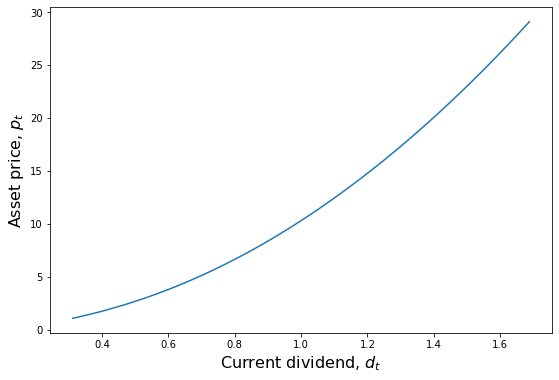

In [8]:
plt.figure(figsize=(9,6))
plt.plot(d_grid,[p_poly(coef_opt,d) for d in d_grid])
plt.xlabel(r'Current dividend, $d_{t}$', fontsize=16)
plt.ylabel(r'Asset price, $p_{t}$', fontsize=16)
plt.show()
plt.close()

#### Measuring the risk premium

The risk-free rate and the expected return are given by the following two equations:

$$
\begin{align}
1 &= \left(1 + r_t^f \right) \beta \mathbb{E}_t \left[ \left( \frac{c_{t+1}}{c_t} \right)^{-\gamma}  \right]
\\
r_{t+1} &= \frac{d_{t+1} + p_{t+1}}{p_t} - 1
\end{align}
$$

We define the risk premium as the difference between the expected return and the risk-free rate:

$$
x_t = \mathbb{E}(r_{t+1}) - r_t^f
$$

Since we already solved for an approximation of the asset price function we can use it to calculate $\mathbb{E}(r_{t+1})$ and $x_t$ given $r_t^f$.

In [9]:
@njit
def riskprem(coef,grid,quad):
    """
    Returns the risk premium, risk free rate and expected return given price function
    """
    
    # Extracting parameters for the quadrature
    q_nodes, q_weights = quad
    
    # Initialize arrays
    Er  = np.zeros_like(grid)  # expected return array
    rfr = np.zeros_like(grid)  # risk free rate array
    temp1 = np.zeros_like(q_nodes)  # array to store xr for every ε before taking expectations
    temp2 = np.zeros_like(q_nodes)  # array to store rfr for every ε before taking expectations
    
    # Computing expected return and risk free rate
    for i in range(len(grid)):
        d = grid[i]
        
        p = p_poly(coef,d)  # Computes the price for d_i
        
        for j in range(len(q_nodes)):  
            ε = q_nodes[j]
            d_new = μ_d + ρ_d * d + σ * np.sqrt(2) * ε
            p_new = p_poly(coef,d_new)
            # Computes the gross rate of return for every realisation of the shock
            temp1[j] = (q_weights[j] / np.sqrt(np.pi)) * ((d_new + p_new) / p)
            # Computes the gross risk free rate for every realisation of the shock
            temp2[j] = (q_weights[j] / np.sqrt(np.pi)) * (β * (d_new / d) ** (-γ))
        
        Er[i] = np.sum(temp1) - 1
        rfr[i] = 1 / np.sum(temp2) - 1
        
    rp = Er - rfr
    
    return Er, rfr, rp


In [10]:
Er, rfr, rp = riskprem(coef_opt,d_grid,gh_quad)

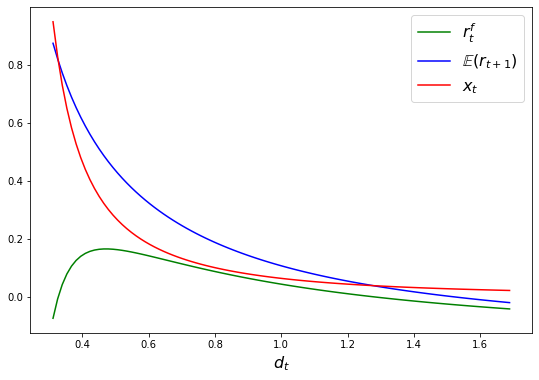

In [11]:
plt.figure(figsize=(9,6))
plt.plot(d_grid, rfr,'-g',label=r'$r_t^f$')
plt.plot(d_grid, Er,'-b',label=r'$\mathbb{E}(r_{t+1})$')
plt.plot(d_grid, rp,'-r',label=r'$x_t$')
plt.legend(loc='best',fontsize=16)
plt.xlabel(r'$d_{t}$', fontsize=16)
plt.show()
plt.close()